In [1]:
import csv
import pandas as pd
import sqlite3
import os

## LOADING NECESSARY FILES

In [2]:
#Loading CSV Files
box_office_data = pd.read_csv("bom.movie_gross.csv.gz")

In [3]:
#Loading SQLite Database
conn = sqlite3.connect("im.db")

In [4]:
box_office_data.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
table_list_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(table_list_query, conn)

print("Available tables:", tables)

Available tables:             name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [6]:
movie_ratings = pd.read_sql("""SELECT * FROM movie_ratings;""", conn)
movie_basics = pd.read_sql("""SELECT * FROM movie_basics;""", conn)

conn.close()

print(movie_ratings.head())
print(movie_basics.head())

     movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726            4.2     50352
4   tt1060240            6.5        21
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80

In [7]:
imdb_data = pd.merge(movie_basics, movie_ratings, on='movie_id', how='left')

print(imdb_data.head())

    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  averagerating  numvotes  
0        2013            175.0    Action,Crime,Drama            7.0      77.0  
1        2019            114.0       Biography,Drama            7.2      43.0  
2        2018            122.0                 Drama            6.9    4517.0  
3        2018              NaN          Comedy,Drama            6.1      13.0  
4        2017             80.0  Comedy,Drama,Fantasy            6.5     119.0  


In [8]:
merged_data = pd.merge(box_office_data, imdb_data, left_on='title', right_on='primary_title', how='left')
print(merged_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
4142                                    The Quake       Magn.          6200.0   
4143                  Edward II (2018 re-release)          FM          4800.0   
4144                                     El Pacto        Sony          2500.0   
4145                                     The Swan  Synergetic          2400.0   
4146                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year   

# MISSING VALUES

## 1. Check if we have missing values

In [9]:
print(merged_data.isna().sum())

title                 0
studio                5
domestic_gross       35
foreign_gross      1631
year                  0
movie_id            781
primary_title       781
original_title      781
start_year          781
runtime_minutes     949
genres              821
averagerating      1120
numvotes           1120
dtype: int64


## 2. Dropping irrelevant columns

In [10]:
merged_data.drop(columns=['original_title', 'start_year', 'numvotes'], inplace=True)

## 3. Handling missing values in relevant columns

In [11]:
# filling missing studio values with 'Unknown'
merged_data['studio'].fillna('Unknown', inplace=True)

# filling missing domestic gross and foreign gross with '0'
merged_data['domestic_gross'].fillna(0, inplace=True)
merged_data['foreign_gross'].fillna(0, inplace=True)

# finding median runtime and replacing missing runtimes
median_runtime = merged_data['runtime_minutes'].median()
merged_data['runtime_minutes'].fillna(median_runtime, inplace=True)

# filling missing genres with 'Unknown'
merged_data['genres'].fillna('Unknown', inplace=True)

# finding mean rating and replace to missing average ratings
mean_rating = merged_data['averagerating'].mean()
merged_data['averagerating'].fillna(mean_rating, inplace=True)

# dropping rows that do not have movie id
merged_data.dropna(subset=['movie_id'], inplace=True)

# check if there are further missing values
print(merged_data.isna().sum())

title              0
studio             0
domestic_gross     0
foreign_gross      0
year               0
movie_id           0
primary_title      0
runtime_minutes    0
genres             0
averagerating      0
dtype: int64


In [12]:
print(merged_data.head())

                        title studio  domestic_gross foreign_gross  year  \
0                 Toy Story 3     BV     415000000.0     652000000  2010   
3                   Inception     WB     292600000.0     535700000  2010   
4         Shrek Forever After   P/DW     238700000.0     513900000  2010   
5  The Twilight Saga: Eclipse   Sum.     300500000.0     398000000  2010   
6                  Iron Man 2   Par.     312400000.0     311500000  2010   

    movie_id               primary_title  runtime_minutes  \
0  tt0435761                 Toy Story 3            103.0   
3  tt1375666                   Inception            148.0   
4  tt0892791         Shrek Forever After             93.0   
5  tt1325004  The Twilight Saga: Eclipse            124.0   
6  tt1228705                  Iron Man 2            124.0   

                       genres  averagerating  
0  Adventure,Animation,Comedy            8.3  
3     Action,Adventure,Sci-Fi            8.8  
4  Adventure,Animation,Comedy      

## Genre Standardization
Same movie could be identified using different names. 

In [13]:
# Clean genre column
def clean_and_explode(df, genre_column):
    df[genre_column] = df[genre_column].str.split(',')
    df = df.explode(genre_column).reset_index(drop=True)
    return df

merged_data = clean_and_explode(merged_data, 'genres')

merged_data['averagerating'] = merged_data['averagerating'].fillna(merged_data['averagerating'].mean())

print(merged_data.head())

         title studio  domestic_gross foreign_gross  year   movie_id  \
0  Toy Story 3     BV     415000000.0     652000000  2010  tt0435761   
1  Toy Story 3     BV     415000000.0     652000000  2010  tt0435761   
2  Toy Story 3     BV     415000000.0     652000000  2010  tt0435761   
3    Inception     WB     292600000.0     535700000  2010  tt1375666   
4    Inception     WB     292600000.0     535700000  2010  tt1375666   

  primary_title  runtime_minutes     genres  averagerating  
0   Toy Story 3            103.0  Adventure            8.3  
1   Toy Story 3            103.0  Animation            8.3  
2   Toy Story 3            103.0     Comedy            8.3  
3     Inception            148.0     Action            8.8  
4     Inception            148.0  Adventure            8.8  


In [14]:
merged_data['domestic_gross'] = pd.to_numeric(merged_data['domestic_gross'], errors='coerce').fillna(0).astype(int)
merged_data['foreign_gross'] = pd.to_numeric(merged_data['foreign_gross'], errors='coerce').fillna(0).astype(int)

# ANALYSIS

## Genre Analysis

In [15]:
# Aggregated Domestic and Foreign Revenue by Genre
genre_revenue = merged_data.groupby('genres')[['domestic_gross', 'foreign_gross', 'averagerating']].agg({
    'domestic_gross': ['sum', 'mean'],
    'foreign_gross': ['sum', 'mean'],
    'averagerating': 'mean'
}).reset_index()

# rename main columns for easier identity
genre_revenue.columns = ['genre', 'total_domestic_gross', 'average_domestic_gross', 'total_foreign_gross', 'average_foreign_gross', 'average_rating']

# Sort by total domestic gross revenue
genre_revenue = genre_revenue.sort_values(by='total_domestic_gross', ascending=False)

print(genre_revenue)

          genre  total_domestic_gross  average_domestic_gross  \
1     Adventure          4.191778e+10            9.398605e+07   
0        Action          3.843915e+10            5.789028e+07   
4        Comedy          3.249809e+10            3.367678e+07   
7         Drama          3.105158e+10            1.655201e+07   
17       Sci-Fi          1.495762e+10            1.076088e+08   
19     Thriller          1.367092e+10            2.854054e+07   
2     Animation          1.362289e+10            8.676997e+07   
5         Crime          9.352542e+09            2.398088e+07   
9       Fantasy          9.288773e+09            5.247895e+07   
16      Romance          7.331809e+09            1.517973e+07   
11       Horror          7.088680e+09            2.715969e+07   
3     Biography          6.420383e+09            2.098164e+07   
8        Family          5.597358e+09            4.339037e+07   
6   Documentary          5.443313e+09            1.629734e+07   
14      Mystery          

# VISUALIZATION

## 1. Genre's ratings
I looked at how each genre is rated 

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

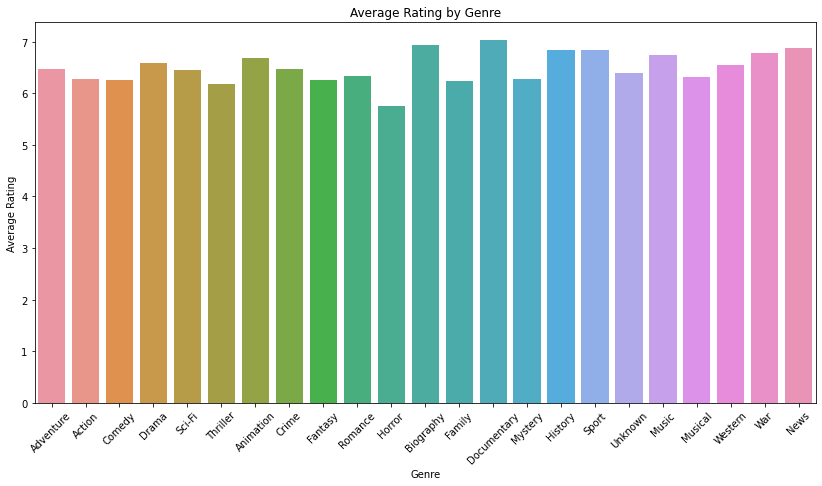

In [17]:
plt.figure(figsize=(14, 7))
sns.barplot(x='genre', y='average_rating', data=genre_revenue)
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

## 2. Genre's Domestic Revenue

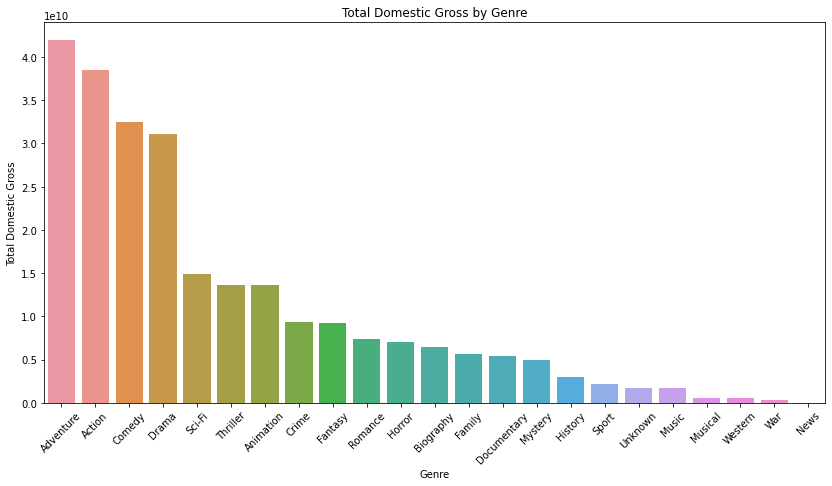

In [18]:
plt.figure(figsize=(14, 7))
sns.barplot(x='genre', y='total_domestic_gross', data=genre_revenue)
plt.title('Total Domestic Gross by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Domestic Gross')
plt.xticks(rotation=45)
plt.show()

## 3. Genre's Foreign Revenue

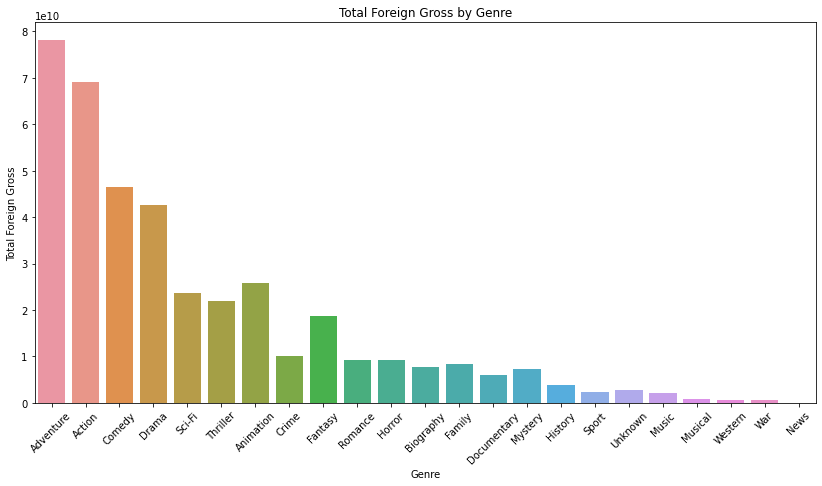

In [19]:
plt.figure(figsize=(14, 7))
sns.barplot(x='genre', y='total_foreign_gross', data=genre_revenue)
plt.title('Total Foreign Gross by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Foreign Gross')
plt.xticks(rotation=45)
plt.show()

## 4. Ratings vs Foreign Revenue

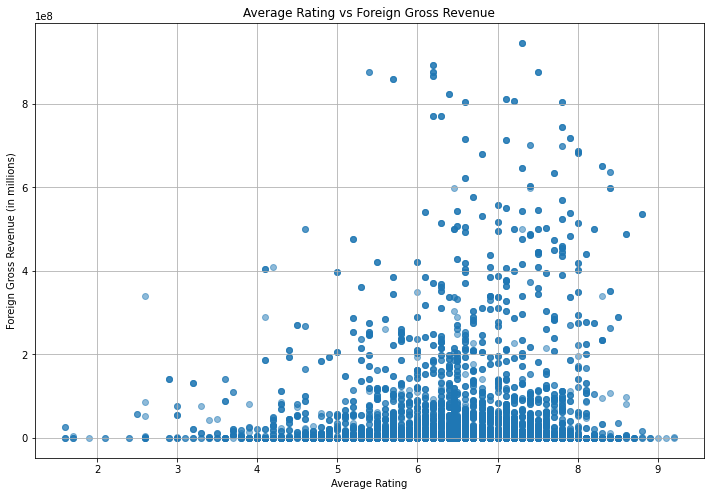

In [20]:
plt.figure(figsize=(12, 8))
plt.scatter(merged_data['averagerating'], merged_data['foreign_gross'], alpha=0.5)
plt.title('Average Rating vs Foreign Gross Revenue')
plt.xlabel('Average Rating')
plt.ylabel('Foreign Gross Revenue (in millions)')
plt.grid(True)
plt.show()